In [1]:
# !pip install seaborn

https://www.kaggle.com/datasets/ashishpatel26/facial-expression-recognitionferchallenge?resource=download

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
# import torchvision
# from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import cv2

C:\Users\cedri\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('./data/fer2013/fer2013/fer2013.csv')

print(df.shape)
print(df.emotion.unique()) # How many emotions?
df.head()

(35887, 3)
[0 2 4 6 3 5 1]


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


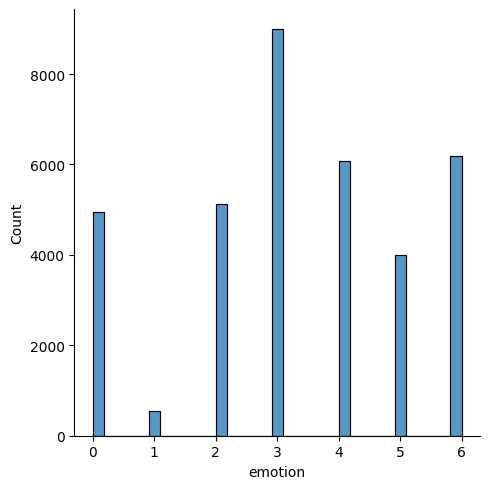

In [3]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
sns.displot(df.emotion)
plt.show()

## Data Preparation

### Convert to (m, height, width, channels) for CNN

In [4]:
X = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
X = np.stack(X, axis=0)
print(X.shape)

y = np.array(df.emotion)

(35887, 48, 48, 1)


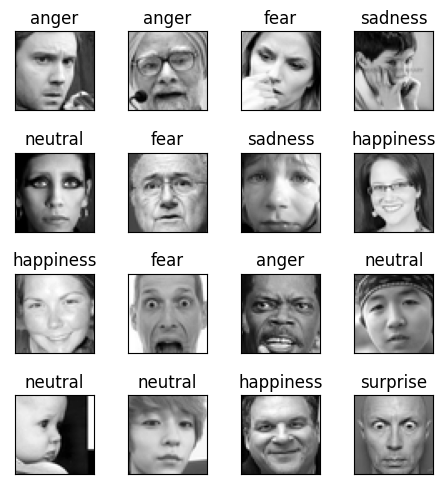

In [5]:
fig = plt.figure(1, (5, 5))
img_size = 48
for i in range(16):
    img = X[i]
    ax = plt.subplot(4,4, i+1)
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(emotion_label_to_text[df.emotion[i]])
    plt.tight_layout()

80% Training
10% validation
10% testing

In [6]:
y

array([0, 0, 2, ..., 0, 3, 2], dtype=int64)

In [7]:
# First separate data into training set and remaining set (to be used for testing and valid)
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, shuffle=True, train_size=0.8)

X_valid, X_test, y_valid, y_test = train_test_split(X_remaining, y_remaining, shuffle=True, test_size=0.5)


print(X_train.shape, X_valid.shape, X_test.shape, y_train.shape)

(28709, 48, 48, 1) (3589, 48, 48, 1) (3589, 48, 48, 1) (28709,)


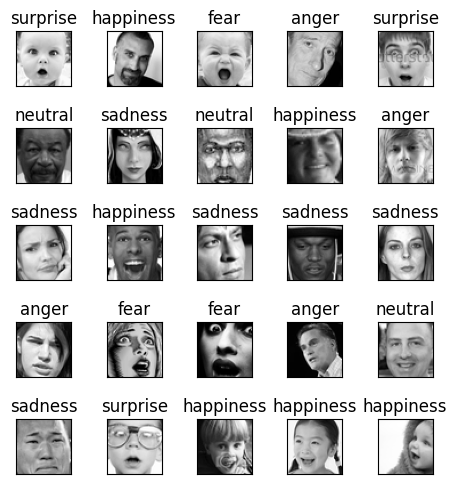

In [8]:
fig = plt.figure(1, (5, 5))
img_size = 48
for i in range(25):
    img = X_train[i]
    ax = plt.subplot(5,5, i+1)
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(emotion_label_to_text[y_train[i]])
    plt.tight_layout()

## Implement batches

In [9]:
class ImgDataset(Dataset):
    def __init__(self, X, y, transform=None, target_transform=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [10]:
print("Done")

Done


In [11]:
# X_train -= np.mean(X_train, axis=0)
# X_train /= np.std(X_train, axis=0)

# X_valid -= np.mean(X_valid, axis=0)
# X_valid /= np.std(X_valid, axis=0)

# X_test -= np.mean(X_test, axis=0)
# X_test /= np.std(X_test, axis=0)


In [12]:
train_data = ImgDataset(X_train, y_train)
valid_data = ImgDataset(X_valid, y_valid)
test_data = ImgDataset(X_test, y_test)

    
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 48, 48, 1])
Labels batch shape: torch.Size([64])


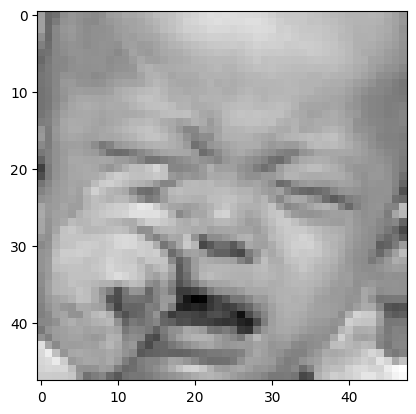

Label: sadness


In [13]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {emotion_label_to_text[label.item()]}")

## Model

In [14]:
class ConvNet_initial(nn.Module):
    def __init__(self, num_classes: int = 10) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(128 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [15]:
class ConvNet(nn.Module):
    def __init__(self, num_classes: int = 7) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            
            # 1st convo layer
            nn.Conv2d(1, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Dropout(),
            
            # 2nd convo layer
            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Dropout(),
            
            # 3rd convo layer
            nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            
        )
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        
        #fully connected neural networks
        self.classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
#         x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
#         x = F.softmax(x, dim=0)
        return x


In [16]:
class ConvNet2(nn.Module):
    def __init__(self, num_classes: int = 7) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            
            # 1st convo layer
            nn.Conv2d(1, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
#             nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
#             nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Dropout(),
            
            # 2nd convo layer
            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
#             nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
#             nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Dropout(),
            
            # 3rd convo layer
            nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
#             nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
#             nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            
        )
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        
        #fully connected neural networks
        self.classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
#         x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
#         x = F.softmax(x, dim=1)
        return x


In [17]:
class ConvNetBatchNorm(nn.Module):
    def __init__(self, num_classes: int = 7) -> None:
        super().__init__()
        self.num_classes = num_classes
        self.features = nn.Sequential(
            
            # 1st convo layer
            nn.Conv2d(1, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Dropout(),
            
            # 2nd convo layer
            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            nn.Dropout(),
            
            # 3rd convo layer
            nn.Conv2d(64, 128, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=(3,3), padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=(2,2), stride=2),
            
        )
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        
        #fully connected neural networks
        self.classifier = nn.Sequential(
            nn.Linear(128 * 6 * 6, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
#         x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
#         x = F.softmax(x, dim=1)
        return x


In [275]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)


num_classes = 7
print("Num classes", num_classes)
criterion = nn.CrossEntropyLoss()
model = ConvNet2(num_classes=num_classes).to(device)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Using device cuda:0
Num classes 7


In [36]:

def train_model(model, dataloaders, criterion, optimizer, num_epochs=30, weights_name='weight_save', is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    loss_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            
            for inputs, labels in dataloaders[phase]:
                
                inputs = inputs.permute(0,3,1,2)
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4 * loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()
            
            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("Epoch time taken: ", elapsed_epoch)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + "_state_dict.pth")
                torch.save(model, weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history, train_acc_history


In [34]:
dataloaders = { 'train': train_dataloader, 'val': valid_dataloader }

## ConvNet. Optim ADAM, LR=1e-4

In [278]:
best_model, val_acc_history, loss_acc_history = train_model(model, dataloaders, criterion, optimizer, 30, 'convet_bestsofar')

Epoch 0/29
----------
train Loss: 1.8333 Acc: 0.2438
Epoch time taken:  23.996994256973267
val Loss: 1.8741 Acc: 0.2444
Epoch time taken:  24.436996698379517

Epoch 1/29
----------
train Loss: 1.7474 Acc: 0.2922
Epoch time taken:  22.603997468948364
val Loss: 1.6309 Acc: 0.3597
Epoch time taken:  23.037997484207153

Epoch 2/29
----------
train Loss: 1.5565 Acc: 0.3985
Epoch time taken:  22.675003051757812
val Loss: 1.4700 Acc: 0.4296
Epoch time taken:  23.134000778198242

Epoch 3/29
----------
train Loss: 1.4545 Acc: 0.4418
Epoch time taken:  17.427000522613525
val Loss: 1.3883 Acc: 0.4589
Epoch time taken:  19.87303853034973

Epoch 4/29
----------
train Loss: 1.3641 Acc: 0.4775
Epoch time taken:  26.37801742553711
val Loss: 1.3313 Acc: 0.4870
Epoch time taken:  26.864013195037842

Epoch 5/29
----------
train Loss: 1.2980 Acc: 0.5060
Epoch time taken:  23.78800344467163
val Loss: 1.2615 Acc: 0.5099
Epoch time taken:  24.370006322860718

Epoch 6/29
----------
train Loss: 1.2420 Acc: 0.5

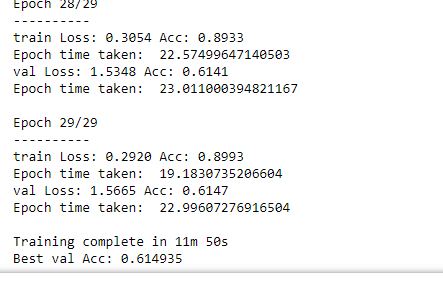

In [28]:
def plot_data(val_acc_history, loss_acc_history, train_acc_history):
    plt.plot(loss_acc_history, label = 'Validation')
    plt.title('Loss per epoch')
    plt.legend()
    plt.show()
    plt.plot([x.cpu() for x in val_acc_history], label = 'Validation')
    plt.plot([x.cpu() for x in train_acc_history], label = 'Training')
    plt.title('Accuracy per epoch')
    plt.legend()
    plt.show()

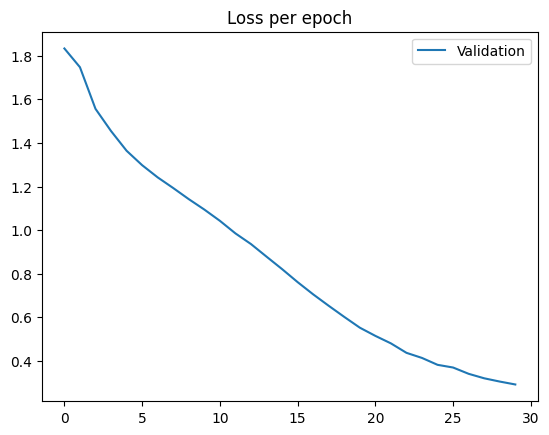

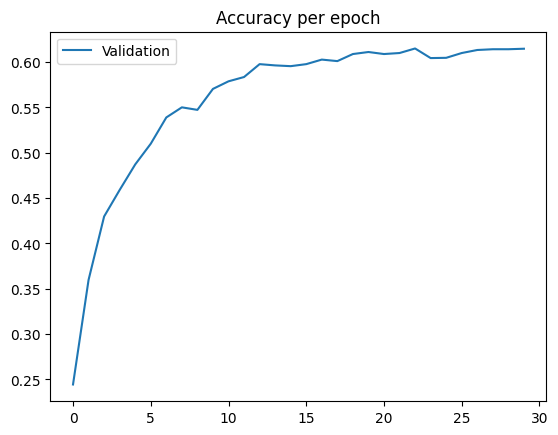

In [279]:
plot_data(val_acc_history, loss_acc_history)


## ConvNet. Optim SGD, LR=0.002 WITH BATCH NORM

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)


num_classes = 7
print("Num classes", num_classes)
criterion4 = nn.CrossEntropyLoss()
model4 = ConvNetBatchNorm(num_classes=num_classes).to(device)
optimizer4 = optim.SGD(model4.parameters(), lr=0.002, momentum=0.9)
best_model4, val_acc_history4, loss_acc_history4, train_acc_history4 = train_model(model4, dataloaders, 
                                                                                   criterion4, optimizer4, 30, 
                                                                                   'convnet_SGD_BATCHNORM')

Using device cuda:0
Num classes 7
Epoch 0/29
----------
train Loss: 1.7369 Acc: 0.2921
Epoch time taken:  68.86119341850281
val Loss: 1.6044 Acc: 0.3759
Epoch time taken:  69.48520231246948

Epoch 1/29
----------
train Loss: 1.5411 Acc: 0.4015
Epoch time taken:  75.02113819122314
val Loss: 1.4625 Acc: 0.4355
Epoch time taken:  75.54214310646057

Epoch 2/29
----------
train Loss: 1.4249 Acc: 0.4494
Epoch time taken:  74.11243772506714
val Loss: 1.3445 Acc: 0.4921
Epoch time taken:  74.58443641662598

Epoch 3/29
----------
train Loss: 1.3436 Acc: 0.4829
Epoch time taken:  66.64930987358093
val Loss: 1.2841 Acc: 0.5110
Epoch time taken:  67.19131183624268

Epoch 4/29
----------
train Loss: 1.2800 Acc: 0.5089
Epoch time taken:  72.37864470481873
val Loss: 1.2570 Acc: 0.5060
Epoch time taken:  72.86764621734619

Epoch 5/29
----------
train Loss: 1.2287 Acc: 0.5322
Epoch time taken:  79.0474202632904
val Loss: 1.2015 Acc: 0.5372
Epoch time taken:  79.58148288726807

Epoch 6/29
----------
tra

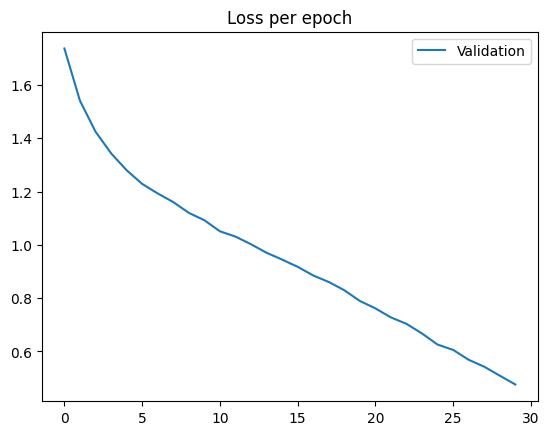

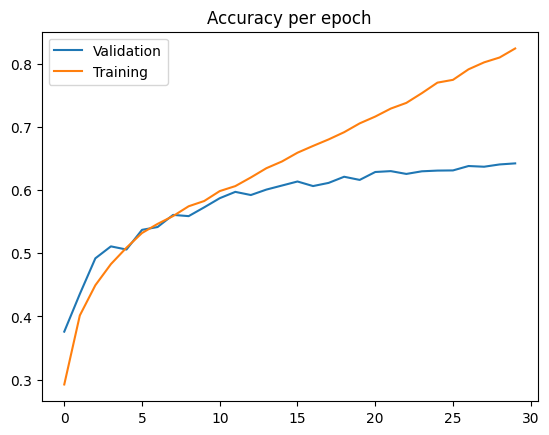

In [41]:
plot_data(val_acc_history4, loss_acc_history4, train_acc_history4)

## ConvNet. Optim ADAM, WITH BATCH NORM

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)


num_classes = 7
print("Num classes", num_classes)
criterion3 = nn.CrossEntropyLoss()
model3 = ConvNetBatchNorm(num_classes=num_classes).to(device)
optimizer3 = optim.Adam(model3.parameters(), lr=1e-4)
best_model3, val_acc_history3, loss_acc_history3, train_acc_history3 = train_model(model3, dataloaders, 
                                                                                   criterion3, optimizer3, 
                                                                                   30, 'convnet_ADAM_BATCHNORM')

tensor([4], device='cuda:0')


Text(0.5, 1.0, 'Prediction: sadness | Actual: anger')

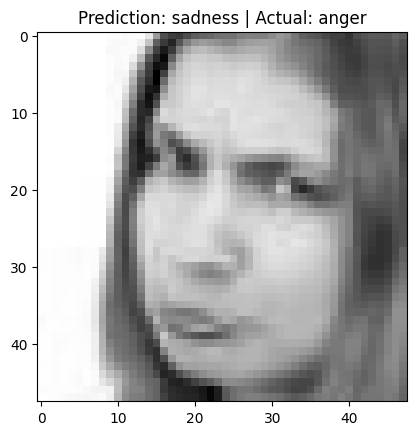

In [300]:
# Quick test

model_adam = ConvNet2(7).to(device)
model_adam.load_state_dict(torch.load('./convnet_ADAM_0.01.pth'))
model.eval()
random_choice = np.random.randint(0 , X_test.shape[0]-1)
random_sample = X_test[random_choice]
x = torch.Tensor(random_sample).permute(2,0,1)
x= x[np.newaxis,:,:]
outputs = model_adam(x.to(device))
_, preds = torch.max(outputs, 1)
print(preds)

plt.imshow(random_sample, cmap='gray')
plt.title(f"Prediction: {emotion_label_to_text[preds.item()]} | Actual: {emotion_label_to_text[y_test[random_choice]]}")

In [ ]:
assert False, "breakpoint"

# Open Camera

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
# import torchvision
# from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import cv2

emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using device', device)
num_classes = 7
print("Num classes", num_classes)
criterion = nn.CrossEntropyLoss()
model = ConvNet2(num_classes=num_classes).to(device)


Using device cuda:0
Num classes 7


In [6]:
model.load_state_dict(torch.load('./convnet_ADAM_0.01.pth'))
model.eval()

face_haar_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')

cap=cv2.VideoCapture(0)

while True:
    ret,test_img=cap.read()# captures frame and returns boolean value and captured image
    if not ret:
        continue
    gray_img= cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)

    faces_detected = face_haar_cascade.detectMultiScale(gray_img, 1.32, 5)


    try:
        for (x,y,w,h) in faces_detected:
            cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),thickness=7)
            roi_gray=gray_img[y:y+w,x:x+h]#cropping region of interest i.e. face area from  image
            roi_gray=cv2.resize(roi_gray,(48,48))

            img_pixels = np.array(roi_gray).astype('float32')
            img_pixels = np.expand_dims(img_pixels, axis = 0)
#             img_pixels /= 255

            img_pixels=  torch.Tensor(img_pixels[np.newaxis,: ,: ]).to(device)
            predictions = model(img_pixels)

            _, preds = torch.max(predictions, 1)

            predicted_emotion = emotion_label_to_text[preds.item()]

            cv2.putText(test_img, predicted_emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

        resized_img = cv2.resize(test_img, (1000, 700))
        cv2.imshow('Facial emotion analysis ',resized_img)
    except Exception as error:
        print(error)
        cap.release()
        cv2.destroyAllWindows


    if cv2.waitKey(10) == ord('q'):#wait until 'q' key is pressed
        break

cap.release()
cv2.destroyAllWindows

KeyboardInterrupt: 

##### test=

In [ ]:
# r = np.array(roi_gray).astype('float32')

# plt.imshow(r, cmap='gray')

# img_pixels = np.expand_dims(r, axis = 0)
# # img_pixels /= 255

# img_pixels=  torch.Tensor(img_pixels[np.newaxis,: ,: ]).to(device)
# predictions = model(img_pixels)
# _, preds = torch.max(predictions, 1)

# predicted_emotion = emotion_label_to_text[preds.item()]

# print(predicted_emotion)